In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

In [2]:
tf.__version__

'2.6.4'

# **Visualizing Classes**

In [3]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [4]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<AxesSubplot:>

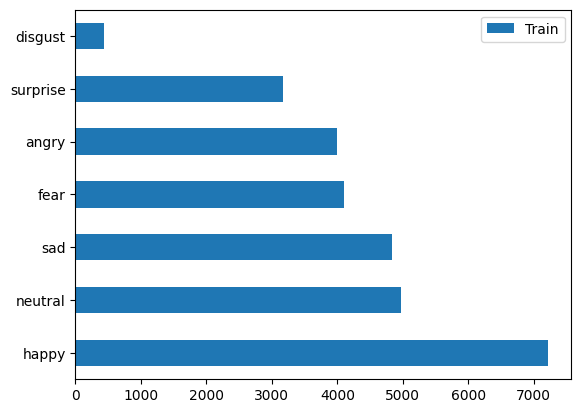

In [5]:
Train_Count.plot(kind='barh')

<AxesSubplot:>

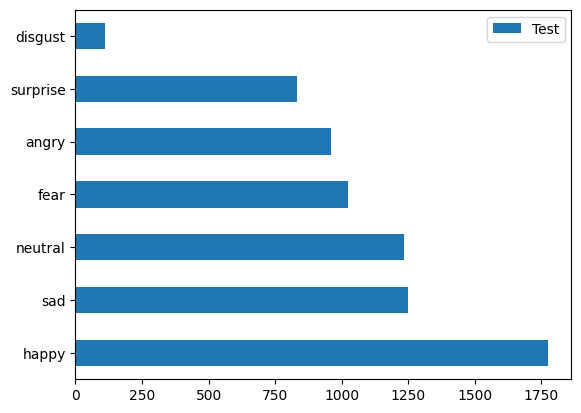

In [6]:
Test_Count.plot(kind='barh')

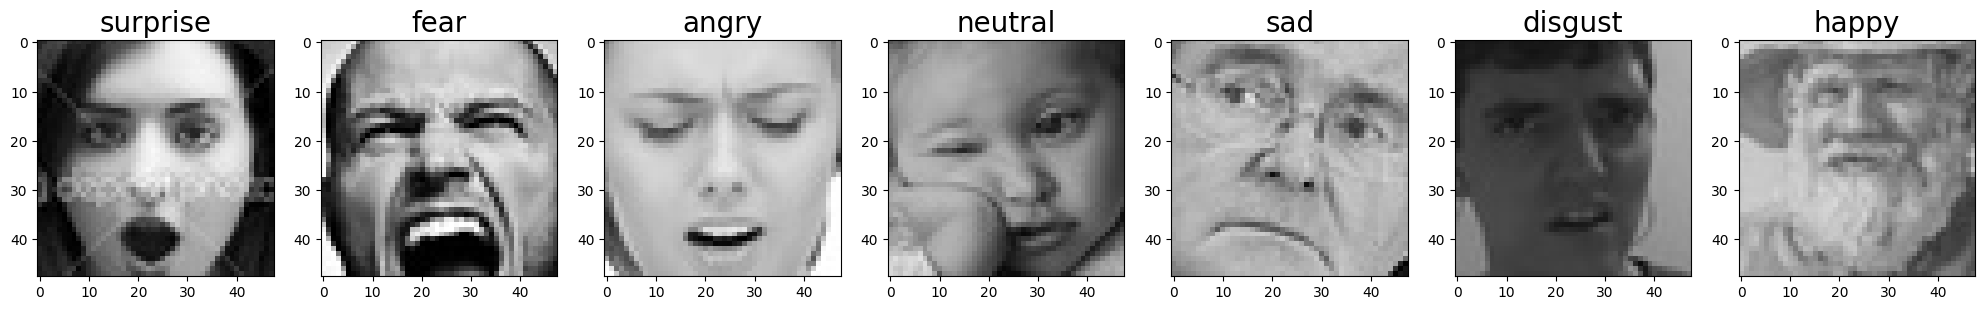

In [7]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '../input/fer2013/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

In [8]:
img_shape = 48
batch_size = 64
train_data_path = '../input/fer2013/train/'
test_data_path = '../input/fer2013/test/'

In [9]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building CNN Model**

In [10]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

In [11]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()

In [12]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

**Specifying Callbacks**

In [13]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [14]:
CNN_history = CNN_Model.fit(train_data, validation_data=test_data, epochs=60, batch_size=batch_size,
                            callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - 256s 547ms/step - loss: 2.0356 - accuracy: 0.2106 - precision: 0.2324 - recall: 0.0247 - val_loss: 1.8303 - val_accuracy: 0.2532 - val_precision: 0.4347 - val_recall: 0.0520
Epoch 2/60
448/448 [==============================] - 60s 135ms/step - loss: 1.7583 - accuracy: 0.2942 - precision: 0.5047 - recall: 0.0453 - val_loss: 1.6640 - val_accuracy: 0.3372 - val_precision: 0.4928 - val_recall: 0.2157
Epoch 3/60
448/448 [==============================] - 60s 134ms/step - loss: 1.6225 - accuracy: 0.3661 - precision: 0.6411 - recall: 0.1122 - val_loss: 1.4792 - val_accuracy: 0.4357 - val_precision: 0.6517 - val_recall: 0.2316
Epoch 4/60
448/448 [==============================] - 60s 133ms/step - loss: 1.4940 - accuracy: 0.4273 - precision: 0.7084 - recall: 0.1768 - val_loss: 1.6218 - val_accuracy: 0.3484 - val_precision: 0.6986 - val_recall: 0.0925
Epoch 5/60
448/448 [==============================] - 62s 137ms/step - loss: 1.4037 - accur

# **Evaluating CNN Model**

In [36]:
CNN_Score = CNN_Model.evaluate(test_data)

print("Test Loss     : {:.5f}".format(CNN_Score[0]))
print("Test Accuracy : {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 8s 71ms/step - loss: 0.9493 - accuracy: 0.6447 - precision: 0.7576 - recall: 0.5248
Test Loss     : 0.94929
Test Accuracy : 64.47%


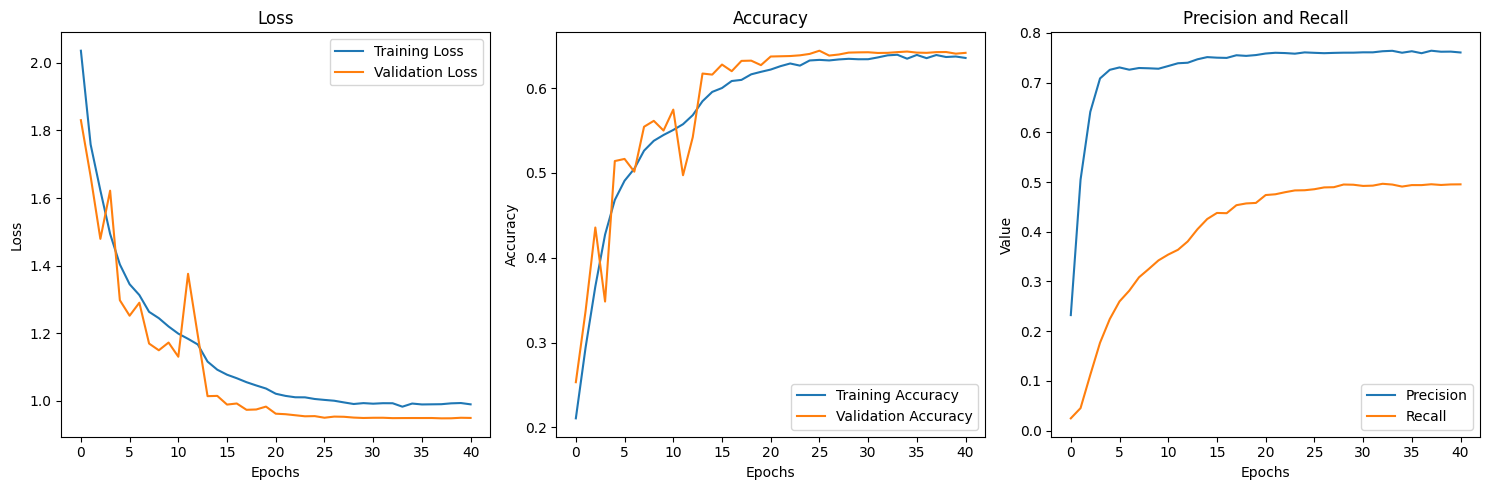

In [37]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    precision = history.history["precision"]
    recall = history.history["recall"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot precision and recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, precision, label="Precision")
    plt.plot(epochs, recall, label="Recall")
    plt.title("Precision and Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_curves function after training
plot_curves(CNN_history)


In [38]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [39]:
history = CNN_history
final_accuracy = history.history['accuracy'][-1]
final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]
final_val_loss = history.history['val_loss'][-1]
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))

******** Final Metrics ********
Final Accuracy        : 63.57%
Final Precision       : 76.06%
Final Recall          : 49.53%
Final Validation Loss : 0.9498
Final F1 Score        : 0.6


Text(0.5, 1.0, 'CNN Confusion Matrix')

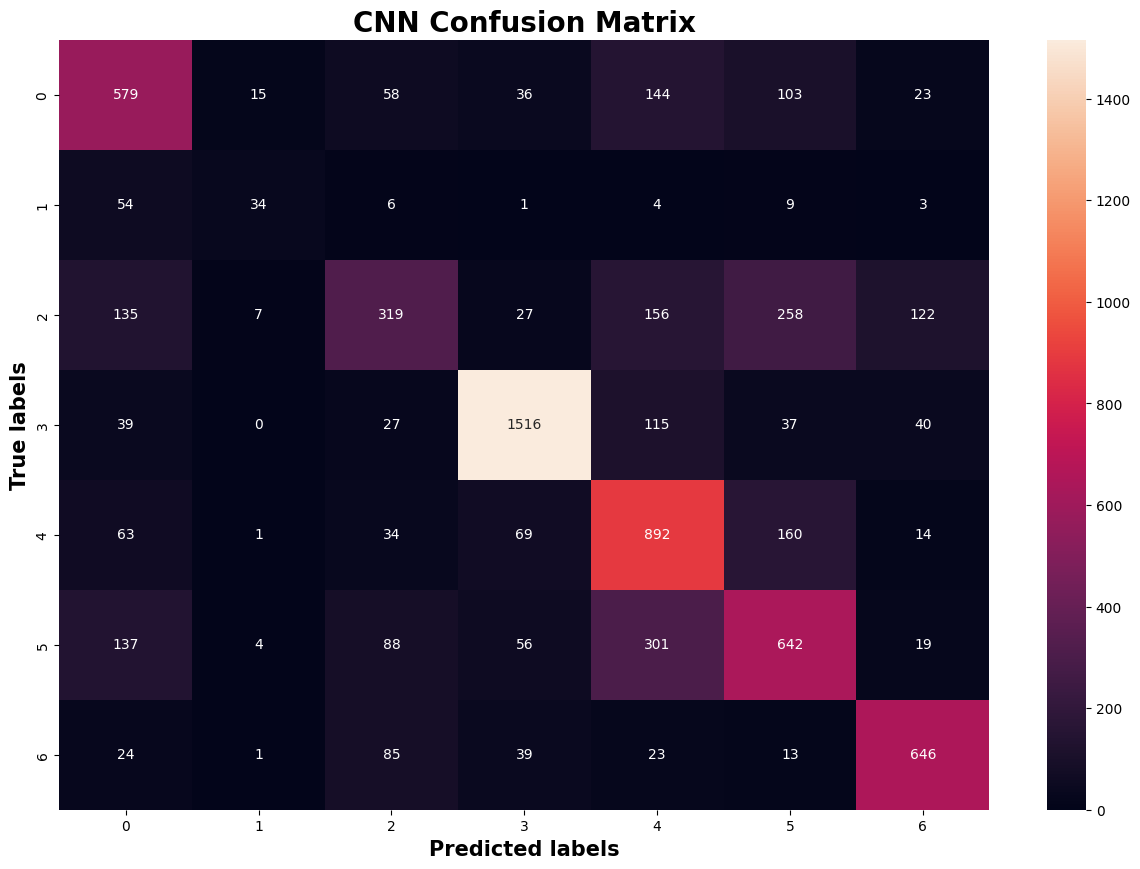

In [40]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [41]:
class_indices = test_data.class_indices
Emotion_Classes = [key.capitalize() for key in class_indices.keys()]
print(Emotion_Classes)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [42]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


**CNN Predictions**

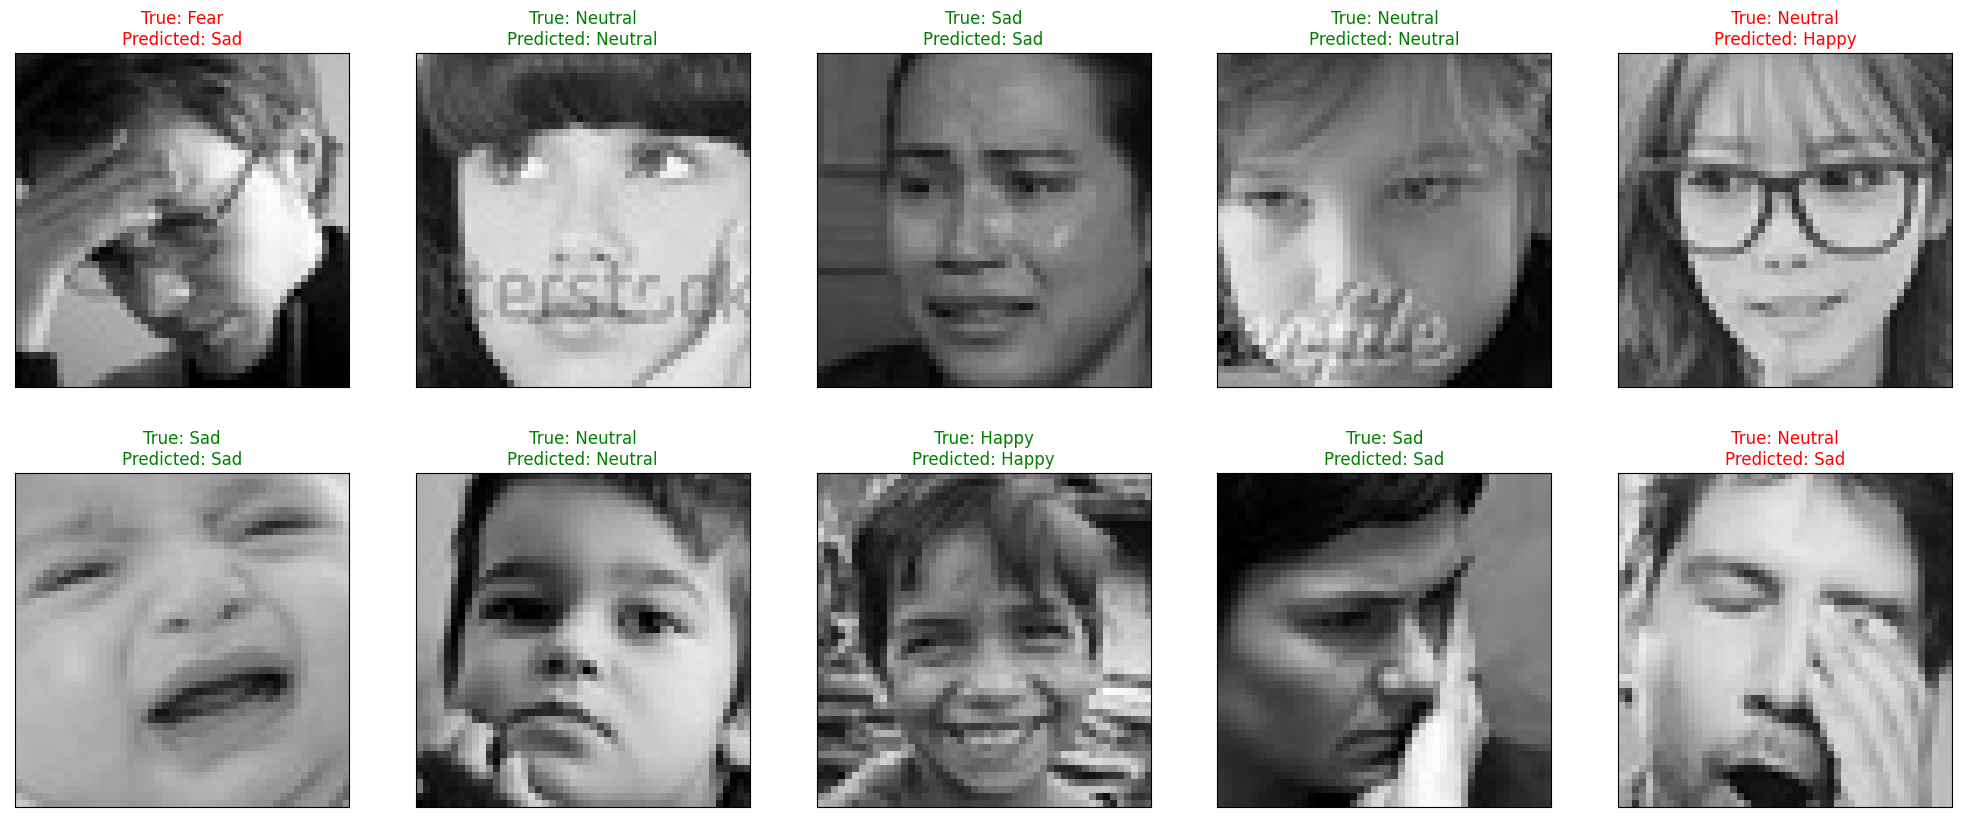

<Figure size 640x480 with 0 Axes>

In [46]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **Music Recommendations**

In [44]:
Music_Player = pd.read_csv("../input/spotify-music-data-to-identify-the-moods/data_moods.csv")
Music_Player = Music_Player[['name','artist','mood','popularity']]
Music_Player.head()

,name,artist,mood,popularity
0,1999,Prince,Happy,68
1,23,Blonde Redhead,Sad,43
2,9 Crimes,Damien Rice,Sad,60
3,99 Luftballons,Nena,Happy,2
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic,60


In [45]:
Music_Player["mood"].value_counts()

Sad          197
Calm         195
Energetic    154
Happy        140
Name: mood, dtype: int64

In [25]:
Music_Player["popularity"].value_counts()

0     92
51    23
52    22
50    21
55    21
      ..
80     1
2      1
14     1
15     1
88     1
Name: popularity, Length: 83, dtype: int64

In [26]:
Play = Music_Player[Music_Player['mood'] =='Calm' ]
Play = Play.sort_values(by="popularity", ascending=False)
Play = Play[:3].reset_index(drop=True)
display(Play)

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60


In [27]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):
    
    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['mood'] =='Sad' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['mood'] =='Happy' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['mood'] =='Calm' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

In [28]:
# Example Testing
Recommend_Songs("Happy")

,name,artist,mood,popularity
0,Pumped Up Kicks,Foster The People,Happy,84
1,Africa,TOTO,Happy,84
2,Take on Me,a-ha,Happy,84
3,Highway to Hell,AC/DC,Happy,83
4,Here Comes The Sun - Remastered 2009,The Beatles,Happy,83


# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [29]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")    

--2024-05-07 10:15:07--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2024-05-07 10:15:07 (16.3 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [30]:
import cv2
import matplotlib.pyplot as plt

def load_and_prep_image(filename, img_shape = 48):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    for x,y,w,h in faces:
        
        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        
        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]
    
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg



In [31]:
def pred_and_plot(filename, class_names, size):

    # Import the target image and preprocess it
    Random_Img = load_and_prep_image(filename, size)

    # Make a prediction
    Model_Prediction = np.argmax(CNN_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))
    pred_class = class_names[Model_Prediction]
    print("Sentiment Identified as: ", pred_class)
   
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()


Sentiment Identified as:  Happy


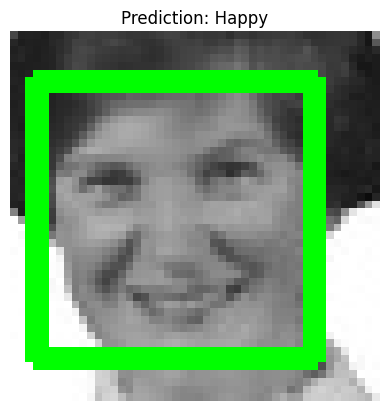

In [32]:
pred_and_plot("../input/fer2013/test/happy/PrivateTest_218533.jpg", Emotion_Classes, 48)

In [33]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg" -O sad.jpg

--2024-05-07 10:15:09--  https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 72.21.91.70, 2606:2800:220:1410:489:141e:20bb:12f6
Connecting to pbs.twimg.com (pbs.twimg.com)|72.21.91.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36922 (36K) [image/jpeg]
Saving to: ‘sad.jpg’

sad.jpg             100%[===================>]  36.06K  --.-KB/s    in 0.01s   

2024-05-07 10:15:09 (3.40 MB/s) - ‘sad.jpg’ saved [36922/36922]



Sentiment Identified as:  Sad


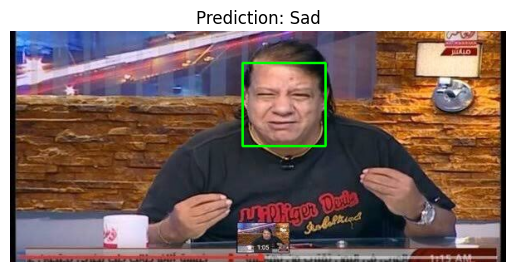

In [34]:
pred_and_plot("./sad.jpg", Emotion_Classes, 48)

In [47]:
CNN_Model.save("CNN_Model.h5")